The Tile images used in the project were created by Matthias Felleisen and found on his website
https://felleisen.org/matthias/4500-f19/tiles.html

1. Filename: Tsuro(No Rotations Seen)
2. Version number: 1
3. Creation date: 4th October 2022
4. Last modification date: 27th April 2023
5. Author’s name: Joseph Henry
6. Purpose of the program: Define a reinforcement learning environment based on the board game Tsuro along with an agent to train using the environment.

In [1]:
!pip install gym
!pip install pygame
!pip install tf_agents==0.15.0
!pip install tensorflow
!pip install matplotlib
!pip install numpy


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gym
import numpy as np
import pygame
import time
import random
from gym import spaces
from gym.envs.registration import register
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# player piece colors [player1, player2]
colors = ['#FF0000', '#0000FF']

# paths for each tile 1-35
node_combinations = [ 
    [(0,3), (1,5), (2,6), (4,7)], [(0,4), (1,5), (2,6), (3,7)], [(0,3), (1,6), (2,5), (4,7)], [(0,6), (1,5), (2,4), (3,7)],
    [(0,1), (2,3), (4,5), (6,7)], [(0,4), (1,5), (2,3), (6,7)], [(0,6), (1,5), (2,3), (4,7)], [(0,5), (1,4), (2,7), (3,6)],
    [(0,5), (1,4), (2,6), (3,7)], [(0,3), (1,4), (2,5), (6,7)], [(0,6), (1,4), (2,5), (3,7)], [(0,5), (1,4), (2,3), (6,7)],
    [(0,2), (1,3), (4,6), (5,7)], [(0,2), (1,3), (4,5), (6,7)], [(0,5), (1,3), (2,7), (4,6)], [(0,6), (1,3), (2,7), (4,5)],
    [(0,4), (1,3), (2,6), (5,7)], [(0,5), (1,3), (2,6), (4,7)], [(0,4), (1,3), (2,5), (6,7)], [(0,6), (1,3), (2,5), (4,7)],
    [(0,5), (1,3), (2,4), (6,7)], [(0,6), (1,3), (2,4), (5,7)], [(0,3), (1,2), (4,7), (5,6)], [(0,3), (1,2), (4,6), (5,7)],
    [(0,3), (1,2), (4,5), (6,7)], [(0,4), (1,2), (3,7), (5,6)], [(0,5), (1,2), (3,7), (4,6)], [(0,6), (1,2), (3,7), (4,5)],
    [(0,4), (1,2), (3,6), (5,7)], [(0,5), (1,2), (3,6), (4,7)], [(0,4), (1,2), (3,5), (6,7)], [(0,6), (1,2), (3,5), (4,7)],
    [(0,5), (1,2), (3,4), (6,7)], [(0,6), (1,2), (3,4), (5,7)], [(0,7), (1,2), (3,4), (5,6)]
]


In [3]:
# Class modelling the tile cards used within Tsuro
class Tile():
    def __init__(self, tile_num, tile_connections):
        self.tile_num = tile_num
        self.image = pygame.image.load("TsuroImages/" + str(tile_num) + ".png")
        self.image = pygame.transform.scale(self.image, (100, 100))
        self.tile_connections = tile_connections
        self.rotation = 1
    # decide where the player should move to
    def move(self, current_node):
        next_node = 0
        next_player_tile = 0
        for connection in self.tile_connections:
            if current_node in connection:
                n1, n2 = connection
                if n1 == current_node:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n2)
                else:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n1)
                return next_node, next_player_tile, next_x, next_y
        raise Exception("Issue in moving players")
    
    # update number of times rotation should be applied to connections and image
    def rotate_tile(self, rotate):
        self.image = pygame.transform.rotate(self.image, rotate * -90)
        self.tile_connections = [tuple((element + (2 * rotate)) % 8 for element in couple ) for couple in self.tile_connections]
        self.rotation = 1 if (self.rotation + 1 % 4 == 0) else self.rotation + 1
    
    # get the current rotation value of the tile
    def get_rotation(self):
        return self.rotation
    
    # decide which tile and node the player should move to from its current position on this tile
    def new_tile_node(self, current_node):
        next_node = 0
        next_x = 0
        next_y = 0
        next_player_tile = 0
        match current_node:
            case 0:
                next_node = 3
                next_player_tile = -1
                next_x = -1
            case 1:
                next_node = 6
                next_player_tile = -6
                next_y = -1
            case 2:
                next_node = 5
                next_player_tile = -6
                next_y = -1
            case 3:
                next_node = 0
                next_player_tile = 1
                next_x = 1
            case 4:
                next_node = 7
                next_player_tile = 1
                next_x = 1
            case 5:
                next_node = 2
                next_player_tile = 6
                next_y = 1
            case 6:
                next_node = 1
                next_player_tile = 6
                next_y = 1
            case 7:
                next_node = 4
                next_player_tile = -1
                next_x = -1
            case _:
                raise Exception("Issue in tile board")
                
        return next_node, next_player_tile, next_x, next_y
    

In [4]:
# Class to model the board game Tsuro as a reinforcement learning environment.
class TsuroEnv(gym.Env):
    # initialise the environment
    def __init__(self):
        self.current_player = 1
        self.num_tiles = 35
        self.tile_board_size = (6, 6)
        self.player_board_size = (36,8)
        self.num_players = 2
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)

        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
        
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)

        self.action_space = spaces.Discrete(11)
        self.observation_space = spaces.Box(low=-1, high=35, shape=(327,))
        
    # Resets the environment to default state
    def reset(self): 
        self.current_player = 1
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)
        
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)
            
        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
            
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        #########################################
        #TODO: TESTING STUFF TO BE REMOVED LATER#
        #########################################
        for i in range(self.num_players):
            self.player_board[random.randint(0,5)][i+1] = i+1
            
        initial_obs = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.tile_board.flatten()))

        return initial_obs
    
    # Makes a move in the game based on inputs from player or AI
    def step(self, action = -2, move = -1):
        if move == -1:
            card, rotate = self.get_card(action)
        else:
            card = move
            rotate = 0
        
        action = self.player_tiles[self.current_player - 1][card]
        
        if action == -1:
            observation = np.hstack((self.player_tiles[self.current_player - 1], 
                                     self.player_board.flatten(), self.tile_board.flatten()))
            reward = -1
            done = 0
            return observation, reward, done, {}
            
        # Removes used tile and adds new tile from deck to hand
        self.player_tiles[self.current_player-1].remove(action)
        if len(self.remaining_tiles) > 0:
            self.player_tiles[self.current_player-1].append(self.remaining_tiles.pop())
        else:
            self.player_tiles[self.current_player-1].append(-1)
        
        # Rotates tile (Only used by AI)
        self.tiles[action].rotate_tile(rotate)
        
        reward = 0
        self.place_tile(action+1)
        self.move_players()
        reward = self.reward_function()
        if self.game_is_over():
            done = 1
        else:
            done = 0
        self.current_player = self.next_player()
        observation = np.hstack((self.player_tiles[self.current_player - 1],
                                 self.player_board.flatten(), self.tile_board.flatten()))
        return observation, reward, done, {}
    
    # Decides if the game is over
    def game_is_over(self):
        if len(self.remaining_players) <= 1:
            return True
        return False
    
    # Decides the reward (Only used for AI)
    def reward_function(self):
        if not self.game_is_over():
            return 1
        if self.game_is_over() and self.current_player in self.remaining_players:
            return 2
        return -1
    
    # Places tile in self.tile_board
    def place_tile(self, tile):
        tile_number, node_number = np.where(self.player_board == self.current_player)
        x, y = TsuroEnv.euclidean_division(self, tile_number)
        x = x[0]
        y = y[0]
        self.tile_board[x][y] += tile
    
    # Moves player piece in self.player_board
    def move_players(self):
        for player in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == player)
            x, y = TsuroEnv.euclidean_division(self, tile_number)
            x = x[0]
            y = y[0]
            while self.tile_board[x][y] != 0:
                tile = self.tiles[(self.tile_board[x][y])-1]
                next_node, next_player_tile, next_x, next_y = tile.move(node_number)
                self.player_board[tile_number[0]][node_number[0]] = 0
                if ((tile_number[0] % 6 == 0) and ((tile_number[0] + next_player_tile) % 6 == 5)) or (tile_number[0] + next_player_tile < 0) or (tile_number[0] + next_player_tile > 35) or ((tile_number[0] % 6 == 5) and ((tile_number[0] + next_player_tile) % 6 == 0)):
                    self.remaining_players.remove(player)
                    break
                else:
                    self.player_board[tile_number[0] + next_player_tile][next_node] = player
                    x += next_x
                    y += next_y
                    tile_number, node_number = np.where(self.player_board == player)
    
    # Quotient and Remainder
    def euclidean_division(self, x, y = 6):
        return x % y, x // y
    
    # Action (card, rotation) from input
    def get_card(self, x, y = 4):
        return  x // y, x % y
    
    # Gets the current state of the environment
    def get_state(self):
        observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.tile_board.flatten()))
        return observation

    # Decide whos turn it is
    def next_player(self):
        if len(self.remaining_players) == 0:
            return -1
        if self.current_player not in self.remaining_players:
            for player in self.remaining_players:
                if player > self.current_player:
                    return player
                else:
                    return self.remaining_players[0]
        return self.remaining_players[(self.remaining_players.index(self.current_player) + 1) % len(self.remaining_players)]
        
    # Render the environment
    def render(self, mode):
        screen = pygame.display.set_mode((650, 750))
        screen.fill((255, 255, 255))

        # Draw the game board
        board = pygame.image.load("TsuroImages/board.png")
        board = pygame.transform.scale(board, (600, 600))
        screen.blit(board, (25,25))
        
        # Draw current players hand
        for i in range (len(self.player_tiles[self.current_player-1])):
            tile = self.player_tiles[self.current_player-1][i]
            screen.blit(self.tiles[tile].image, (75 + (i * 200), 635))
        
        # Draw the tiles on the board
        for x in range(self.tile_board_size[0]):
            for y in range(self.tile_board_size[1]):
                val = self.tile_board[x][y]
                if val != 0:
                    tile = self.tiles[val-1]
                    screen.blit(tile.image, (25 + x * 100, 25 + y * 100))
                    
        # Draw the players' pieces on the board
        for i in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == i)
            y_add = 0
            x_add = 0
            y_mult = 0
            x_mult = 0
            
            match node_number[0]:
                case 0:
                    y_add = 35
                case 1:
                    x_add = 35
                case 2:
                    x_add = 70
                case 3:
                    x_add = 100
                    y_add = 35
                case 4:
                    x_add = 100
                    y_add = 70
                case 5:
                    x_add = 70
                    y_add = 100
                case 6:
                    x_add = 35
                    y_add = 100
                case 7:
                     y_add = 70
                case _:
                    raise Exception("Issue in drawing the player board")
                    
            if tile_number[0] != 0:
                x_mult, y_mult = TsuroEnv.euclidean_division(self, tile_number[0])
            
            pygame.draw.circle(screen, colors[i-1], (25 + x_add + (100 * x_mult), 25 + y_add + (100 * y_mult)), 5)
            
        # Draw text to show who won when game is over
        if self.game_is_over() or self.current_player == -1:
            font = pygame.font.Font('freesansbold.ttf', 32)
            text = font.render('Player ' + str(self.current_player) + ' wins', True, '#00FF00')
            textRect = text.get_rect()
            textRect.center = (650 // 2, 750 // 2)
            screen.blit(text, textRect)
            
        pygame.display.update()


In [5]:
# Training hyper parameters
num_iterations = 25000000
initial_collect_steps = 5000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 100
learning_rate = 1e-3
log_interval = 200
num_eval_episodes = 20
eval_interval = 5000

# Register the environment through gym
register(
    id='TsuroEnvBasic',
    entry_point=TsuroEnv,
)

env_name = "TsuroEnvBasic"

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (200, 100)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
    
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step)
    # commenting out render will make training quicker
    # environment.render("human")
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

train_checkpointer = common.Checkpointer(
    ckpt_dir="Checkpoints2/",
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

train_checkpointer.initialize_or_restore()

In [6]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

agent.train = common.function(agent.train)

returns = []

with open("Checkpoints2/returns.txt", "r") as txt:
    for line in txt:
        returns.append(line)
        
for i in range(len(returns)):
    returns[i] = returns[i].strip()
    returns[i] = float(returns[i])
    

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
# Initial Collection for new agent
'''
collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
'''

'\ncollect_data(train_env, random_policy, replay_buffer, initial_collect_steps)\nagent.train_step_counter.assign(0)\n\navg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)\nreturns = [avg_return]\n'

In [8]:
for _ in range(num_iterations):
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        train_checkpointer.save(train_step_counter)
        with open("Checkpoints2/returns.txt", "w") as txt:
            for item in returns:
                txt.write(str(item) + "\n")

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 2510200: loss = 4.048866271972656
step = 2510400: loss = 2.711169481277466
step = 2510600: loss = 2.831785202026367
step = 2510800: loss = 4.045544147491455
step = 2511000: loss = 3.755446434020996
step = 2511200: loss = 3.416694164276123
step = 2511400: loss = 2.1397054195404053
step = 2511600: loss = 3.3178164958953857
step = 2511800: loss = 3.104382038116455
step = 2512000: loss = 4.317492485046387
step = 2512200: loss = 3.75129771232605
step = 2512400: loss = 3.5067083835601807
step = 2512600: loss = 2.9723024368286133
step = 2512800: loss = 3.127715587615967
step = 2513000: loss = 3.5993614196777344
step = 2513200: loss = 5.463475227355957
step = 2513400: loss = 2.5705113410949707
step = 2513600: loss = 3.66930890083313
step = 2513800: loss = 2.8041768074035645
step = 2514000: loss = 2.736694574356079
step = 2514200: loss = 4.450831890106201
step = 2514400: loss = 2.989251136779785
step = 2514600: loss = 3.52043080329895
step = 2514800: loss = 3.02284574508667
step = 251500

step = 2548200: loss = 2.157727003097534
step = 2548400: loss = 3.6423330307006836
step = 2548600: loss = 3.1738977432250977
step = 2548800: loss = 2.767191171646118
step = 2549000: loss = 5.5469841957092285
step = 2549200: loss = 2.707580804824829
step = 2549400: loss = 3.2502684593200684
step = 2549600: loss = 2.703089475631714
step = 2549800: loss = 3.366084575653076
step = 2550000: loss = 2.7421765327453613
step = 2550000: Average Return = 4.75
step = 2550200: loss = 3.4008564949035645
step = 2550400: loss = 4.933030128479004
step = 2550600: loss = 2.678490161895752
step = 2550800: loss = 2.9693222045898438
step = 2551000: loss = 3.899578809738159
step = 2551200: loss = 2.7278358936309814
step = 2551400: loss = 2.2267513275146484
step = 2551600: loss = 4.242767810821533
step = 2551800: loss = 3.538522243499756
step = 2552000: loss = 3.027844190597534
step = 2552200: loss = 4.073752403259277
step = 2552400: loss = 2.639488697052002
step = 2552600: loss = 2.7111473083496094
step = 25

step = 2586000: loss = 3.124817371368408
step = 2586200: loss = 3.1143736839294434
step = 2586400: loss = 3.2300448417663574
step = 2586600: loss = 2.7157094478607178
step = 2586800: loss = 4.058740615844727
step = 2587000: loss = 3.338604688644409
step = 2587200: loss = 3.1129956245422363
step = 2587400: loss = 2.9943435192108154
step = 2587600: loss = 2.627328634262085
step = 2587800: loss = 4.344545364379883
step = 2588000: loss = 3.4886484146118164
step = 2588200: loss = 3.652071714401245
step = 2588400: loss = 2.7342641353607178
step = 2588600: loss = 3.734679698944092
step = 2588800: loss = 2.646418333053589
step = 2589000: loss = 3.9943525791168213
step = 2589200: loss = 3.67970609664917
step = 2589400: loss = 3.430471658706665
step = 2589600: loss = 3.288140296936035
step = 2589800: loss = 4.000049114227295
step = 2590000: loss = 4.310790538787842
step = 2590000: Average Return = 4.349999904632568
step = 2590200: loss = 3.606550931930542
step = 2590400: loss = 3.739993095397949

step = 2624200: loss = 2.5450093746185303
step = 2624400: loss = 2.220459461212158
step = 2624600: loss = 3.50508713722229
step = 2624800: loss = 2.0219886302948
step = 2625000: loss = 3.335392475128174
step = 2625000: Average Return = 3.75
step = 2625200: loss = 2.863750457763672
step = 2625400: loss = 3.366926908493042
step = 2625600: loss = 2.711125135421753
step = 2625800: loss = 3.3607935905456543
step = 2626000: loss = 3.473520517349243
step = 2626200: loss = 3.7116847038269043
step = 2626400: loss = 2.9988527297973633
step = 2626600: loss = 3.612630844116211
step = 2626800: loss = 2.929960012435913
step = 2627000: loss = 2.065577983856201
step = 2627200: loss = 2.9000494480133057
step = 2627400: loss = 4.394617080688477
step = 2627600: loss = 3.0426340103149414
step = 2627800: loss = 3.6971001625061035
step = 2628000: loss = 1.785845160484314
step = 2628200: loss = 2.8554821014404297
step = 2628400: loss = 2.101391315460205
step = 2628600: loss = 5.1456499099731445
step = 262880

step = 2662200: loss = 3.381899356842041
step = 2662400: loss = 3.0700621604919434
step = 2662600: loss = 3.7657225131988525
step = 2662800: loss = 2.6732499599456787
step = 2663000: loss = 2.8280718326568604
step = 2663200: loss = 2.2484099864959717
step = 2663400: loss = 2.8268446922302246
step = 2663600: loss = 1.8743817806243896
step = 2663800: loss = 2.409698963165283
step = 2664000: loss = 2.595264196395874
step = 2664200: loss = 2.50045108795166
step = 2664400: loss = 2.4013671875
step = 2664600: loss = 2.384348154067993
step = 2664800: loss = 3.5517003536224365
step = 2665000: loss = 3.056777238845825
step = 2665000: Average Return = 3.5
step = 2665200: loss = 2.942471504211426
step = 2665400: loss = 3.0386221408843994
step = 2665600: loss = 2.343806028366089
step = 2665800: loss = 3.346177816390991
step = 2666000: loss = 3.195348024368286
step = 2666200: loss = 3.4184746742248535
step = 2666400: loss = 4.262916088104248
step = 2666600: loss = 3.9704906940460205
step = 2666800:

step = 2700000: Average Return = 3.549999952316284
step = 2700200: loss = 4.511680603027344
step = 2700400: loss = 3.3166093826293945
step = 2700600: loss = 3.0568673610687256
step = 2700800: loss = 4.413233757019043
step = 2701000: loss = 3.651874303817749
step = 2701200: loss = 2.8103344440460205
step = 2701400: loss = 3.664243698120117
step = 2701600: loss = 3.8443148136138916
step = 2701800: loss = 2.878333330154419
step = 2702000: loss = 3.4415996074676514
step = 2702200: loss = 1.7710567712783813
step = 2702400: loss = 2.1470940113067627
step = 2702600: loss = 2.5661418437957764
step = 2702800: loss = 2.5534543991088867
step = 2703000: loss = 2.5576584339141846
step = 2703200: loss = 3.0795092582702637
step = 2703400: loss = 4.28232479095459
step = 2703600: loss = 2.898602247238159
step = 2703800: loss = 2.697442054748535
step = 2704000: loss = 4.617446422576904
step = 2704200: loss = 2.418473958969116
step = 2704400: loss = 3.5156755447387695
step = 2704600: loss = 3.88723874092

step = 2738000: loss = 7.657233715057373
step = 2738200: loss = 3.3923444747924805
step = 2738400: loss = 4.633528709411621
step = 2738600: loss = 2.853543519973755
step = 2738800: loss = 3.637834310531616
step = 2739000: loss = 3.856658935546875
step = 2739200: loss = 2.886582612991333
step = 2739400: loss = 2.696573495864868
step = 2739600: loss = 3.340240001678467
step = 2739800: loss = 5.548066139221191
step = 2740000: loss = 3.750075578689575
step = 2740000: Average Return = 5.550000190734863
step = 2740200: loss = 4.199072360992432
step = 2740400: loss = 5.223312854766846
step = 2740600: loss = 2.3409347534179688
step = 2740800: loss = 3.807110548019409
step = 2741000: loss = 3.9105961322784424
step = 2741200: loss = 5.43275260925293
step = 2741400: loss = 3.4452085494995117
step = 2741600: loss = 3.8545193672180176
step = 2741800: loss = 2.4824037551879883
step = 2742000: loss = 2.819568157196045
step = 2742200: loss = 2.6137218475341797
step = 2742400: loss = 2.116792917251587


step = 2775800: loss = 3.0471179485321045
step = 2776000: loss = 3.096787452697754
step = 2776200: loss = 4.0198845863342285
step = 2776400: loss = 3.907235622406006
step = 2776600: loss = 3.9241185188293457
step = 2776800: loss = 3.9264659881591797
step = 2777000: loss = 1.4314799308776855
step = 2777200: loss = 5.775545597076416
step = 2777400: loss = 3.4712228775024414
step = 2777600: loss = 4.659541606903076
step = 2777800: loss = 3.090432643890381
step = 2778000: loss = 4.867247104644775
step = 2778200: loss = 4.301934719085693
step = 2778400: loss = 2.3440403938293457
step = 2778600: loss = 4.046743869781494
step = 2778800: loss = 3.991426944732666
step = 2779000: loss = 2.945340394973755
step = 2779200: loss = 2.7819125652313232
step = 2779400: loss = 2.421208381652832
step = 2779600: loss = 3.5682647228240967
step = 2779800: loss = 4.330775737762451
step = 2780000: loss = 2.4547760486602783
step = 2780000: Average Return = 3.049999952316284
step = 2780200: loss = 2.747217655181

step = 2813800: loss = 3.839897394180298
step = 2814000: loss = 2.832841396331787
step = 2814200: loss = 3.38753342628479
step = 2814400: loss = 3.8953981399536133
step = 2814600: loss = 3.943134069442749
step = 2814800: loss = 3.4579973220825195
step = 2815000: loss = 3.223841428756714
step = 2815000: Average Return = 6.25
step = 2815200: loss = 3.5930662155151367
step = 2815400: loss = 2.1957461833953857
step = 2815600: loss = 2.9757869243621826
step = 2815800: loss = 4.219380855560303
step = 2816000: loss = 4.381907939910889
step = 2816200: loss = 3.195312976837158
step = 2816400: loss = 4.447340488433838
step = 2816600: loss = 2.293313503265381
step = 2816800: loss = 3.9432103633880615
step = 2817000: loss = 3.8291921615600586
step = 2817200: loss = 2.4946484565734863
step = 2817400: loss = 4.158511638641357
step = 2817600: loss = 2.430424213409424
step = 2817800: loss = 3.6725873947143555
step = 2818000: loss = 2.8682169914245605
step = 2818200: loss = 3.1790220737457275
step = 28

step = 2851600: loss = 3.2105870246887207
step = 2851800: loss = 3.2431609630584717
step = 2852000: loss = 3.383578300476074
step = 2852200: loss = 2.6810412406921387
step = 2852400: loss = 3.2870864868164062
step = 2852600: loss = 3.4920177459716797
step = 2852800: loss = 3.1592302322387695
step = 2853000: loss = 3.9330732822418213
step = 2853200: loss = 3.434661865234375
step = 2853400: loss = 3.715247631072998
step = 2853600: loss = 3.587968111038208
step = 2853800: loss = 3.8207855224609375
step = 2854000: loss = 4.7128095626831055
step = 2854200: loss = 3.8896923065185547
step = 2854400: loss = 2.1688575744628906
step = 2854600: loss = 3.444999933242798
step = 2854800: loss = 2.44864559173584
step = 2855000: loss = 3.5471179485321045
step = 2855000: Average Return = 1.399999976158142
step = 2855200: loss = 3.760585308074951
step = 2855400: loss = 4.154103755950928
step = 2855600: loss = 6.029599666595459
step = 2855800: loss = 3.551370143890381
step = 2856000: loss = 4.20489025115

step = 2889600: loss = 4.105504035949707
step = 2889800: loss = 3.762542724609375
step = 2890000: loss = 3.8663837909698486
step = 2890000: Average Return = 2.549999952316284
step = 2890200: loss = 3.348818302154541
step = 2890400: loss = 3.6847853660583496
step = 2890600: loss = 2.9363768100738525
step = 2890800: loss = 3.7503325939178467
step = 2891000: loss = 1.561279058456421
step = 2891200: loss = 3.8533549308776855
step = 2891400: loss = 3.624660015106201
step = 2891600: loss = 4.434710502624512
step = 2891800: loss = 3.3921895027160645
step = 2892000: loss = 4.484179496765137
step = 2892200: loss = 6.055502414703369
step = 2892400: loss = 2.849550485610962
step = 2892600: loss = 3.903944730758667
step = 2892800: loss = 3.546522855758667
step = 2893000: loss = 3.403686761856079
step = 2893200: loss = 3.2271111011505127
step = 2893400: loss = 3.1027445793151855
step = 2893600: loss = 4.222938537597656
step = 2893800: loss = 3.405149459838867
step = 2894000: loss = 3.77327013015747

step = 2927400: loss = 3.51348876953125
step = 2927600: loss = 3.1322381496429443
step = 2927800: loss = 2.8963210582733154
step = 2928000: loss = 2.919368267059326
step = 2928200: loss = 2.470257043838501
step = 2928400: loss = 2.602710485458374
step = 2928600: loss = 3.0272581577301025
step = 2928800: loss = 3.2868359088897705
step = 2929000: loss = 3.757803201675415
step = 2929200: loss = 2.262524366378784
step = 2929400: loss = 5.772360801696777
step = 2929600: loss = 3.6523406505584717
step = 2929800: loss = 3.3765218257904053
step = 2930000: loss = 2.9159319400787354
step = 2930000: Average Return = 5.099999904632568
step = 2930200: loss = 3.6547088623046875
step = 2930400: loss = 4.010072231292725
step = 2930600: loss = 6.074926853179932
step = 2930800: loss = 2.704352855682373
step = 2931000: loss = 4.0349884033203125
step = 2931200: loss = 3.933281660079956
step = 2931400: loss = 3.552727699279785
step = 2931600: loss = 4.976625442504883
step = 2931800: loss = 2.60866141319274

step = 2965200: loss = 4.190619945526123
step = 2965400: loss = 2.6807568073272705
step = 2965600: loss = 4.84339714050293
step = 2965800: loss = 2.648712396621704
step = 2966000: loss = 4.1675543785095215
step = 2966200: loss = 4.129074573516846
step = 2966400: loss = 3.0912322998046875
step = 2966600: loss = 3.9739274978637695
step = 2966800: loss = 3.183173656463623
step = 2967000: loss = 3.7416930198669434
step = 2967200: loss = 2.7887589931488037
step = 2967400: loss = 4.59602165222168
step = 2967600: loss = 3.681481122970581
step = 2967800: loss = 2.83400821685791
step = 2968000: loss = 3.674056053161621
step = 2968200: loss = 2.241224765777588
step = 2968400: loss = 3.467829465866089
step = 2968600: loss = 2.8963494300842285
step = 2968800: loss = 2.74027156829834
step = 2969000: loss = 3.6749589443206787
step = 2969200: loss = 3.168048620223999
step = 2969400: loss = 2.720005512237549
step = 2969600: loss = 3.6850907802581787
step = 2969800: loss = 2.7566606998443604
step = 297

step = 3003200: loss = 3.2824318408966064
step = 3003400: loss = 3.576420783996582
step = 3003600: loss = 2.591184616088867
step = 3003800: loss = 4.559401988983154
step = 3004000: loss = 2.6515402793884277
step = 3004200: loss = 3.326951742172241
step = 3004400: loss = 3.6440367698669434
step = 3004600: loss = 2.6922929286956787
step = 3004800: loss = 3.26889705657959
step = 3005000: loss = 3.2423949241638184
step = 3005000: Average Return = 5.050000190734863
step = 3005200: loss = 4.1907525062561035
step = 3005400: loss = 2.6395366191864014
step = 3005600: loss = 2.6265881061553955
step = 3005800: loss = 2.199538469314575
step = 3006000: loss = 3.307614326477051
step = 3006200: loss = 2.8010690212249756
step = 3006400: loss = 2.899445056915283
step = 3006600: loss = 3.0155751705169678
step = 3006800: loss = 3.9581639766693115
step = 3007000: loss = 3.4799859523773193
step = 3007200: loss = 3.7997965812683105
step = 3007400: loss = 3.7727468013763428
step = 3007600: loss = 2.652789354

step = 3041000: loss = 3.1887645721435547
step = 3041200: loss = 5.02045202255249
step = 3041400: loss = 2.806558132171631
step = 3041600: loss = 2.227179527282715
step = 3041800: loss = 4.70228385925293
step = 3042000: loss = 3.1681621074676514
step = 3042200: loss = 3.60589599609375
step = 3042400: loss = 4.1343994140625
step = 3042600: loss = 2.9895992279052734
step = 3042800: loss = 2.661558151245117
step = 3043000: loss = 2.9671428203582764
step = 3043200: loss = 4.0919294357299805
step = 3043400: loss = 2.461470365524292
step = 3043600: loss = 3.975863456726074
step = 3043800: loss = 2.3004002571105957
step = 3044000: loss = 2.9385650157928467
step = 3044200: loss = 2.635371685028076
step = 3044400: loss = 2.209726572036743
step = 3044600: loss = 3.3036155700683594
step = 3044800: loss = 3.1754631996154785
step = 3045000: loss = 1.9701892137527466
step = 3045000: Average Return = 3.799999952316284
step = 3045200: loss = 3.0442543029785156
step = 3045400: loss = 3.2580997943878174

step = 3079000: loss = 2.6715328693389893
step = 3079200: loss = 4.155250549316406
step = 3079400: loss = 2.400670289993286
step = 3079600: loss = 4.840860366821289
step = 3079800: loss = 2.4447455406188965
step = 3080000: loss = 2.952083110809326
step = 3080000: Average Return = 4.650000095367432
step = 3080200: loss = 3.175210475921631
step = 3080400: loss = 2.456993579864502
step = 3080600: loss = 4.0108160972595215
step = 3080800: loss = 3.182685375213623
step = 3081000: loss = 3.723376989364624
step = 3081200: loss = 3.6359148025512695
step = 3081400: loss = 3.1508216857910156
step = 3081600: loss = 3.8351211547851562
step = 3081800: loss = 3.7077105045318604
step = 3082000: loss = 4.144174575805664
step = 3082200: loss = 2.6624979972839355
step = 3082400: loss = 3.213247299194336
step = 3082600: loss = 2.7304155826568604
step = 3082800: loss = 2.9067089557647705
step = 3083000: loss = 3.330641746520996
step = 3083200: loss = 2.5812389850616455
step = 3083400: loss = 4.93998098373

step = 3116800: loss = 2.4213128089904785
step = 3117000: loss = 2.9162211418151855
step = 3117200: loss = 3.3262815475463867
step = 3117400: loss = 2.668717861175537
step = 3117600: loss = 3.692255735397339
step = 3117800: loss = 2.7398157119750977
step = 3118000: loss = 3.150330066680908
step = 3118200: loss = 4.091987609863281
step = 3118400: loss = 2.710566282272339
step = 3118600: loss = 3.8198819160461426
step = 3118800: loss = 3.202409505844116
step = 3119000: loss = 2.5471277236938477
step = 3119200: loss = 2.9545793533325195
step = 3119400: loss = 2.6886205673217773
step = 3119600: loss = 2.717970609664917
step = 3119800: loss = 3.655224561691284
step = 3120000: loss = 5.076142311096191
step = 3120000: Average Return = 3.5999999046325684
step = 3120200: loss = 3.7852818965911865
step = 3120400: loss = 3.3174102306365967
step = 3120600: loss = 3.1277880668640137
step = 3120800: loss = 3.0552620887756348
step = 3121000: loss = 3.024383068084717
step = 3121200: loss = 3.148430824

step = 3154800: loss = 2.808832883834839
step = 3155000: loss = 2.7001516819000244
step = 3155000: Average Return = 4.550000190734863
step = 3155200: loss = 4.375783443450928
step = 3155400: loss = 4.09182071685791
step = 3155600: loss = 2.421567916870117
step = 3155800: loss = 2.675203800201416
step = 3156000: loss = 4.514044761657715
step = 3156200: loss = 3.1010329723358154
step = 3156400: loss = 3.193666934967041
step = 3156600: loss = 3.2446610927581787
step = 3156800: loss = 3.128676176071167
step = 3157000: loss = 2.97686505317688
step = 3157200: loss = 3.184847354888916
step = 3157400: loss = 2.7527413368225098
step = 3157600: loss = 4.125449180603027
step = 3157800: loss = 3.625737428665161
step = 3158000: loss = 3.3333795070648193
step = 3158200: loss = 3.144260883331299
step = 3158400: loss = 4.210293292999268
step = 3158600: loss = 3.0293571949005127
step = 3158800: loss = 2.936622142791748
step = 3159000: loss = 2.9321532249450684
step = 3159200: loss = 4.219292640686035
s

step = 3192600: loss = 2.5499207973480225
step = 3192800: loss = 4.500619888305664
step = 3193000: loss = 2.609356641769409
step = 3193200: loss = 2.97987961769104
step = 3193400: loss = 2.348095655441284
step = 3193600: loss = 3.1818981170654297
step = 3193800: loss = 2.8279812335968018
step = 3194000: loss = 3.328369617462158
step = 3194200: loss = 3.7336156368255615
step = 3194400: loss = 2.546710252761841
step = 3194600: loss = 3.486632823944092
step = 3194800: loss = 3.2114062309265137
step = 3195000: loss = 3.6860976219177246
step = 3195000: Average Return = 3.799999952316284
step = 3195200: loss = 2.759636163711548
step = 3195400: loss = 2.5208332538604736
step = 3195600: loss = 4.607468128204346
step = 3195800: loss = 2.6758065223693848
step = 3196000: loss = 3.9206793308258057
step = 3196200: loss = 4.0325212478637695
step = 3196400: loss = 3.565516233444214
step = 3196600: loss = 2.7635958194732666
step = 3196800: loss = 3.1287059783935547
step = 3197000: loss = 4.10407590866

step = 3230600: loss = 3.7366583347320557
step = 3230800: loss = 3.493878126144409
step = 3231000: loss = 4.770025730133057
step = 3231200: loss = 2.73630690574646
step = 3231400: loss = 3.916651487350464
step = 3231600: loss = 2.7277016639709473
step = 3231800: loss = 3.5528924465179443
step = 3232000: loss = 2.871662139892578
step = 3232200: loss = 4.149856090545654
step = 3232400: loss = 3.0401365756988525
step = 3232600: loss = 3.320990562438965
step = 3232800: loss = 4.350433826446533
step = 3233000: loss = 2.244493007659912
step = 3233200: loss = 3.397700071334839
step = 3233400: loss = 4.257744312286377
step = 3233600: loss = 2.4333882331848145
step = 3233800: loss = 3.9494597911834717
step = 3234000: loss = 2.2448389530181885
step = 3234200: loss = 2.684147357940674
step = 3234400: loss = 3.0021448135375977
step = 3234600: loss = 3.1514244079589844
step = 3234800: loss = 3.772486448287964
step = 3235000: loss = 3.0578114986419678
step = 3235000: Average Return = 3.75
step = 323

step = 3268600: loss = 3.3776228427886963
step = 3268800: loss = 3.007855176925659
step = 3269000: loss = 3.6635169982910156
step = 3269200: loss = 2.7121074199676514
step = 3269400: loss = 2.991455316543579
step = 3269600: loss = 2.8521058559417725
step = 3269800: loss = 2.2301063537597656
step = 3270000: loss = 2.5153393745422363
step = 3270000: Average Return = 3.6500000953674316
step = 3270200: loss = 3.6294188499450684
step = 3270400: loss = 3.0456490516662598
step = 3270600: loss = 3.005620002746582
step = 3270800: loss = 3.343261241912842
step = 3271000: loss = 4.619717121124268
step = 3271200: loss = 4.069950103759766
step = 3271400: loss = 4.117256164550781
step = 3271600: loss = 3.3760251998901367
step = 3271800: loss = 3.422974109649658
step = 3272000: loss = 3.0275142192840576
step = 3272200: loss = 5.160956859588623
step = 3272400: loss = 3.485809326171875
step = 3272600: loss = 3.746927499771118
step = 3272800: loss = 2.3593149185180664
step = 3273000: loss = 2.8437950611

step = 3306400: loss = 2.568593740463257
step = 3306600: loss = 3.2766642570495605
step = 3306800: loss = 3.2660984992980957
step = 3307000: loss = 4.416940689086914
step = 3307200: loss = 2.3537023067474365
step = 3307400: loss = 1.9392189979553223
step = 3307600: loss = 3.04093861579895
step = 3307800: loss = 4.041125774383545
step = 3308000: loss = 3.803685426712036
step = 3308200: loss = 3.001223087310791
step = 3308400: loss = 3.945913076400757
step = 3308600: loss = 2.6946229934692383
step = 3308800: loss = 3.7394497394561768
step = 3309000: loss = 3.8624870777130127
step = 3309200: loss = 2.928513765335083
step = 3309400: loss = 3.6554665565490723
step = 3309600: loss = 2.603045701980591
step = 3309800: loss = 2.858268976211548
step = 3310000: loss = 2.663499116897583
step = 3310000: Average Return = 5.0
step = 3310200: loss = 3.2755510807037354
step = 3310400: loss = 2.436558246612549
step = 3310600: loss = 2.754950523376465
step = 3310800: loss = 4.686131477355957
step = 33110

step = 3344600: loss = 4.017951965332031
step = 3344800: loss = 3.7994158267974854
step = 3345000: loss = 4.1921491622924805
step = 3345000: Average Return = 2.700000047683716
step = 3345200: loss = 2.9047672748565674
step = 3345400: loss = 3.260714054107666
step = 3345600: loss = 4.073824882507324
step = 3345800: loss = 3.187847137451172
step = 3346000: loss = 5.123801231384277
step = 3346200: loss = 4.531785011291504
step = 3346400: loss = 4.345210552215576
step = 3346600: loss = 4.494755268096924
step = 3346800: loss = 3.5486485958099365
step = 3347000: loss = 4.892576694488525
step = 3347200: loss = 4.611588478088379
step = 3347400: loss = 3.8687379360198975
step = 3347600: loss = 2.8864989280700684
step = 3347800: loss = 3.883092164993286
step = 3348000: loss = 3.3559093475341797
step = 3348200: loss = 2.935800075531006
step = 3348400: loss = 2.623154878616333
step = 3348600: loss = 2.933520793914795
step = 3348800: loss = 3.6234843730926514
step = 3349000: loss = 3.06721806526184

step = 3382400: loss = 3.9414873123168945
step = 3382600: loss = 4.241152763366699
step = 3382800: loss = 6.14728307723999
step = 3383000: loss = 2.8730950355529785
step = 3383200: loss = 3.0224626064300537
step = 3383400: loss = 4.294897079467773
step = 3383600: loss = 2.9893953800201416
step = 3383800: loss = 3.7662694454193115
step = 3384000: loss = 3.6611523628234863
step = 3384200: loss = 3.5449914932250977
step = 3384400: loss = 2.744903564453125
step = 3384600: loss = 3.1041221618652344
step = 3384800: loss = 2.986873149871826
step = 3385000: loss = 3.087012767791748
step = 3385000: Average Return = 2.799999952316284
step = 3385200: loss = 4.210818767547607
step = 3385400: loss = 3.1291213035583496
step = 3385600: loss = 4.339074611663818
step = 3385800: loss = 4.530116081237793
step = 3386000: loss = 3.67010760307312
step = 3386200: loss = 4.008792400360107
step = 3386400: loss = 3.432772397994995
step = 3386600: loss = 3.1097655296325684
step = 3386800: loss = 4.12401151657104

step = 3420400: loss = 4.890122413635254
step = 3420600: loss = 2.973360538482666
step = 3420800: loss = 4.449543476104736
step = 3421000: loss = 3.569755792617798
step = 3421200: loss = 6.02864933013916
step = 3421400: loss = 6.622134208679199
step = 3421600: loss = 3.1400134563446045
step = 3421800: loss = 2.234994649887085
step = 3422000: loss = 3.5223281383514404
step = 3422200: loss = 3.2545957565307617
step = 3422400: loss = 2.6648101806640625
step = 3422600: loss = 3.1530187129974365
step = 3422800: loss = 3.2552928924560547
step = 3423000: loss = 3.7408947944641113
step = 3423200: loss = 4.426473140716553
step = 3423400: loss = 4.50949764251709
step = 3423600: loss = 4.290276527404785
step = 3423800: loss = 3.240504026412964
step = 3424000: loss = 3.5126593112945557
step = 3424200: loss = 3.4335265159606934
step = 3424400: loss = 3.7903404235839844
step = 3424600: loss = 4.871089458465576
step = 3424800: loss = 3.1852073669433594
step = 3425000: loss = 2.722904682159424
step = 

step = 3458400: loss = 3.0581254959106445
step = 3458600: loss = 3.0743608474731445
step = 3458800: loss = 3.6028642654418945
step = 3459000: loss = 2.9064910411834717
step = 3459200: loss = 2.2844316959381104
step = 3459400: loss = 2.735285520553589
step = 3459600: loss = 3.745630979537964
step = 3459800: loss = 2.887094736099243
step = 3460000: loss = 4.039612293243408
step = 3460000: Average Return = 5.550000190734863
step = 3460200: loss = 3.027116537094116
step = 3460400: loss = 3.774600028991699
step = 3460600: loss = 3.374187469482422
step = 3460800: loss = 3.5898149013519287
step = 3461000: loss = 3.2900822162628174
step = 3461200: loss = 3.033090829849243
step = 3461400: loss = 4.397043228149414
step = 3461600: loss = 4.93563175201416
step = 3461800: loss = 4.111385822296143
step = 3462000: loss = 4.419529438018799
step = 3462200: loss = 2.98974609375
step = 3462400: loss = 2.842226505279541
step = 3462600: loss = 3.613762140274048
step = 3462800: loss = 3.4666314125061035
ste

step = 3496400: loss = 3.900087833404541
step = 3496600: loss = 3.525827646255493
step = 3496800: loss = 5.180683612823486
step = 3497000: loss = 3.6979362964630127
step = 3497200: loss = 3.083252429962158
step = 3497400: loss = 4.799710750579834
step = 3497600: loss = 3.6291143894195557
step = 3497800: loss = 3.0397515296936035
step = 3498000: loss = 3.6495063304901123
step = 3498200: loss = 3.533487558364868
step = 3498400: loss = 3.14496111869812
step = 3498600: loss = 4.955605506896973
step = 3498800: loss = 4.690998554229736
step = 3499000: loss = 3.8698625564575195
step = 3499200: loss = 3.463017463684082
step = 3499400: loss = 3.5557377338409424
step = 3499600: loss = 3.4401607513427734
step = 3499800: loss = 2.464143991470337
step = 3500000: loss = 1.9352757930755615
step = 3500000: Average Return = 3.049999952316284
step = 3500200: loss = 4.178389072418213
step = 3500400: loss = 2.5809342861175537
step = 3500600: loss = 3.1166350841522217
step = 3500800: loss = 2.7935967445373

step = 3534400: loss = 3.668053388595581
step = 3534600: loss = 2.788156270980835
step = 3534800: loss = 2.9816882610321045
step = 3535000: loss = 3.0504837036132812
step = 3535000: Average Return = 4.400000095367432
step = 3535200: loss = 3.2293286323547363
step = 3535400: loss = 4.116815567016602
step = 3535600: loss = 4.164984226226807
step = 3535800: loss = 3.3003695011138916
step = 3536000: loss = 3.4690158367156982
step = 3536200: loss = 3.458704948425293
step = 3536400: loss = 5.1625657081604
step = 3536600: loss = 3.258537530899048
step = 3536800: loss = 4.001347541809082
step = 3537000: loss = 3.6915643215179443
step = 3537200: loss = 3.2307708263397217
step = 3537400: loss = 4.2666850090026855
step = 3537600: loss = 3.6150922775268555
step = 3537800: loss = 3.0178651809692383
step = 3538000: loss = 3.282864809036255
step = 3538200: loss = 3.34060001373291
step = 3538400: loss = 2.2703566551208496
step = 3538600: loss = 2.905729055404663
step = 3538800: loss = 3.44713807106018

step = 3572000: loss = 3.4677042961120605
step = 3572200: loss = 3.7668895721435547
step = 3572400: loss = 3.324186325073242
step = 3572600: loss = 2.950462818145752
step = 3572800: loss = 2.4828991889953613
step = 3573000: loss = 3.5001168251037598
step = 3573200: loss = 3.133633613586426
step = 3573400: loss = 3.0600054264068604
step = 3573600: loss = 3.4065709114074707
step = 3573800: loss = 3.9815564155578613
step = 3574000: loss = 3.8373842239379883
step = 3574200: loss = 2.9295246601104736
step = 3574400: loss = 3.7383806705474854
step = 3574600: loss = 2.0963380336761475
step = 3574800: loss = 3.876264810562134
step = 3575000: loss = 2.6845343112945557
step = 3575000: Average Return = 4.150000095367432
step = 3575200: loss = 3.5218729972839355
step = 3575400: loss = 4.134249687194824
step = 3575600: loss = 3.115288019180298
step = 3575800: loss = 3.735982894897461
step = 3576000: loss = 2.8165369033813477
step = 3576200: loss = 3.5725696086883545
step = 3576400: loss = 3.8325109

step = 3610000: loss = 2.6585566997528076
step = 3610000: Average Return = 2.049999952316284
step = 3610200: loss = 3.659776210784912
step = 3610400: loss = 3.1472854614257812
step = 3610600: loss = 2.569208860397339
step = 3610800: loss = 3.98736310005188
step = 3611000: loss = 2.9009921550750732
step = 3611200: loss = 3.7474708557128906
step = 3611400: loss = 4.938913345336914
step = 3611600: loss = 3.6494195461273193
step = 3611800: loss = 3.194864511489868
step = 3612000: loss = 3.2201101779937744
step = 3612200: loss = 2.545665740966797
step = 3612400: loss = 2.9692184925079346
step = 3612600: loss = 5.136545181274414
step = 3612800: loss = 3.051640033721924
step = 3613000: loss = 4.490206718444824
step = 3613200: loss = 3.426499605178833
step = 3613400: loss = 3.4677722454071045
step = 3613600: loss = 2.2849996089935303
step = 3613800: loss = 2.918471574783325
step = 3614000: loss = 3.2345573902130127
step = 3614200: loss = 3.2243707180023193
step = 3614400: loss = 2.904364347457

step = 3647800: loss = 2.362133741378784
step = 3648000: loss = 3.2859086990356445
step = 3648200: loss = 3.70816707611084
step = 3648400: loss = 3.088719367980957
step = 3648600: loss = 2.7488460540771484
step = 3648800: loss = 2.7402873039245605
step = 3649000: loss = 3.2958438396453857
step = 3649200: loss = 3.463226795196533
step = 3649400: loss = 3.407548666000366
step = 3649600: loss = 4.125080585479736
step = 3649800: loss = 3.512789726257324
step = 3650000: loss = 2.6286098957061768
step = 3650000: Average Return = 6.099999904632568
step = 3650200: loss = 2.8266453742980957
step = 3650400: loss = 3.4758946895599365
step = 3650600: loss = 2.8993256092071533
step = 3650800: loss = 4.0609660148620605
step = 3651000: loss = 2.73238468170166
step = 3651200: loss = 3.0377776622772217
step = 3651400: loss = 4.341207027435303
step = 3651600: loss = 3.534048080444336
step = 3651800: loss = 2.7369680404663086
step = 3652000: loss = 2.764066219329834
step = 3652200: loss = 3.3006236553192

step = 3685800: loss = 3.1611955165863037
step = 3686000: loss = 4.570422172546387
step = 3686200: loss = 3.1965484619140625
step = 3686400: loss = 2.974740505218506
step = 3686600: loss = 2.944838762283325
step = 3686800: loss = 2.862272024154663
step = 3687000: loss = 2.3200223445892334
step = 3687200: loss = 5.171318054199219
step = 3687400: loss = 3.3974926471710205
step = 3687600: loss = 3.4255151748657227
step = 3687800: loss = 3.200570821762085
step = 3688000: loss = 3.289844512939453
step = 3688200: loss = 5.514200210571289
step = 3688400: loss = 3.560537099838257
step = 3688600: loss = 2.844874143600464
step = 3688800: loss = 5.020442485809326
step = 3689000: loss = 3.492079973220825
step = 3689200: loss = 3.4324655532836914
step = 3689400: loss = 4.820682048797607
step = 3689600: loss = 3.347053050994873
step = 3689800: loss = 2.884279489517212
step = 3690000: loss = 3.916579008102417
step = 3690000: Average Return = 4.849999904632568
step = 3690200: loss = 3.9017608165740967

step = 3724000: loss = 3.611384153366089
step = 3724200: loss = 2.9514904022216797
step = 3724400: loss = 4.106415748596191
step = 3724600: loss = 3.2138118743896484
step = 3724800: loss = 3.402151346206665
step = 3725000: loss = 3.3898589611053467
step = 3725000: Average Return = 4.25
step = 3725200: loss = 3.4489669799804688
step = 3725400: loss = 2.996715545654297
step = 3725600: loss = 3.9606921672821045
step = 3725800: loss = 3.4716625213623047
step = 3726000: loss = 4.517755031585693
step = 3726200: loss = 3.7145402431488037
step = 3726400: loss = 2.8105013370513916
step = 3726600: loss = 3.3325488567352295
step = 3726800: loss = 3.3554887771606445
step = 3727000: loss = 3.0366103649139404
step = 3727200: loss = 4.633983135223389
step = 3727400: loss = 3.830410957336426
step = 3727600: loss = 4.208041191101074
step = 3727800: loss = 4.039253234863281
step = 3728000: loss = 3.2919256687164307
step = 3728200: loss = 3.2544050216674805
step = 3728400: loss = 4.287342548370361
step =

step = 3762000: loss = 4.1406073570251465
step = 3762200: loss = 3.3605308532714844
step = 3762400: loss = 5.121596336364746
step = 3762600: loss = 3.0508928298950195
step = 3762800: loss = 3.286011219024658
step = 3763000: loss = 2.0337021350860596
step = 3763200: loss = 4.5180559158325195
step = 3763400: loss = 3.207272529602051
step = 3763600: loss = 3.9964277744293213
step = 3763800: loss = 3.099693775177002
step = 3764000: loss = 2.9820873737335205
step = 3764200: loss = 4.314655780792236
step = 3764400: loss = 3.0057320594787598
step = 3764600: loss = 2.9106128215789795
step = 3764800: loss = 3.3742733001708984
step = 3765000: loss = 4.198757171630859
step = 3765000: Average Return = 5.449999809265137
step = 3765200: loss = 4.300223350524902
step = 3765400: loss = 4.332664489746094
step = 3765600: loss = 2.7302191257476807
step = 3765800: loss = 3.087137460708618
step = 3766000: loss = 5.823610782623291
step = 3766200: loss = 3.8988213539123535
step = 3766400: loss = 3.1856791973

step = 3800000: Average Return = 6.050000190734863
step = 3800200: loss = 4.187519550323486
step = 3800400: loss = 2.323606014251709
step = 3800600: loss = 2.8347320556640625
step = 3800800: loss = 4.97605562210083
step = 3801000: loss = 3.8010048866271973
step = 3801200: loss = 2.2236168384552
step = 3801400: loss = 2.394995927810669
step = 3801600: loss = 3.439944267272949
step = 3801800: loss = 4.960782051086426
step = 3802000: loss = 2.8694000244140625
step = 3802200: loss = 3.6375041007995605
step = 3802400: loss = 2.952967405319214
step = 3802600: loss = 6.276061058044434
step = 3802800: loss = 3.552154779434204
step = 3803000: loss = 3.5906624794006348
step = 3803200: loss = 3.395392417907715
step = 3803400: loss = 3.047852039337158
step = 3803600: loss = 3.0159056186676025
step = 3803800: loss = 6.139599323272705
step = 3804000: loss = 4.347929954528809
step = 3804200: loss = 4.107839107513428
step = 3804400: loss = 3.617885112762451
step = 3804600: loss = 2.6505911350250244
st

step = 3838200: loss = 4.328580379486084
step = 3838400: loss = 2.978532075881958
step = 3838600: loss = 3.3221001625061035
step = 3838800: loss = 3.931842803955078
step = 3839000: loss = 3.707749843597412
step = 3839200: loss = 3.888216972351074
step = 3839400: loss = 3.5848007202148438
step = 3839600: loss = 4.165458679199219
step = 3839800: loss = 3.3393919467926025
step = 3840000: loss = 3.7048919200897217
step = 3840000: Average Return = 4.550000190734863
step = 3840200: loss = 2.3524160385131836
step = 3840400: loss = 3.1828019618988037
step = 3840600: loss = 4.460833549499512
step = 3840800: loss = 3.866865873336792
step = 3841000: loss = 3.0906574726104736
step = 3841200: loss = 4.039029121398926
step = 3841400: loss = 2.715959310531616
step = 3841600: loss = 4.157931327819824
step = 3841800: loss = 3.293135643005371
step = 3842000: loss = 3.701974630355835
step = 3842200: loss = 4.259430408477783
step = 3842400: loss = 3.6171889305114746
step = 3842600: loss = 4.29711627960205

step = 3876000: loss = 3.377720832824707
step = 3876200: loss = 4.198748588562012
step = 3876400: loss = 3.9326934814453125
step = 3876600: loss = 2.4661200046539307
step = 3876800: loss = 3.1037631034851074
step = 3877000: loss = 4.155612468719482
step = 3877200: loss = 5.174822807312012
step = 3877400: loss = 4.824097633361816
step = 3877600: loss = 3.6873650550842285
step = 3877800: loss = 2.977609157562256
step = 3878000: loss = 4.880309104919434
step = 3878200: loss = 3.4487555027008057
step = 3878400: loss = 2.723778247833252
step = 3878600: loss = 2.4979922771453857
step = 3878800: loss = 3.716766357421875
step = 3879000: loss = 4.404689311981201
step = 3879200: loss = 4.124814987182617
step = 3879400: loss = 2.675067663192749
step = 3879600: loss = 3.8605751991271973
step = 3879800: loss = 3.4222352504730225
step = 3880000: loss = 4.146021842956543
step = 3880000: Average Return = 5.800000190734863
step = 3880200: loss = 3.665090799331665
step = 3880400: loss = 6.11738014221191

step = 3914000: loss = 3.9030654430389404
step = 3914200: loss = 4.985601902008057
step = 3914400: loss = 4.281737327575684
step = 3914600: loss = 3.2892651557922363
step = 3914800: loss = 2.7037718296051025
step = 3915000: loss = 6.154417514801025
step = 3915000: Average Return = 6.199999809265137
step = 3915200: loss = 2.8147974014282227
step = 3915400: loss = 3.4008638858795166
step = 3915600: loss = 3.413227081298828
step = 3915800: loss = 5.128626823425293
step = 3916000: loss = 3.6986515522003174
step = 3916200: loss = 4.286086082458496
step = 3916400: loss = 4.987081050872803
step = 3916600: loss = 2.644049644470215
step = 3916800: loss = 3.0951504707336426
step = 3917000: loss = 4.588283061981201
step = 3917200: loss = 3.4534599781036377
step = 3917400: loss = 3.5867345333099365
step = 3917600: loss = 3.459689140319824
step = 3917800: loss = 4.000692367553711
step = 3918000: loss = 3.0302586555480957
step = 3918200: loss = 5.169615745544434
step = 3918400: loss = 3.722937583923

step = 3951800: loss = 3.8238048553466797
step = 3952000: loss = 2.733431100845337
step = 3952200: loss = 2.6188085079193115
step = 3952400: loss = 3.6595394611358643
step = 3952600: loss = 3.42525577545166
step = 3952800: loss = 4.293863296508789
step = 3953000: loss = 2.467414617538452
step = 3953200: loss = 3.226491928100586
step = 3953400: loss = 3.5277600288391113
step = 3953600: loss = 3.0286922454833984
step = 3953800: loss = 5.376009464263916
step = 3954000: loss = 3.1829795837402344
step = 3954200: loss = 2.5156664848327637
step = 3954400: loss = 3.9854564666748047
step = 3954600: loss = 2.2004218101501465
step = 3954800: loss = 4.02056884765625
step = 3955000: loss = 4.063931941986084
step = 3955000: Average Return = 4.800000190734863
step = 3955200: loss = 2.578580379486084
step = 3955400: loss = 2.768812894821167
step = 3955600: loss = 3.7087175846099854
step = 3955800: loss = 4.293032169342041
step = 3956000: loss = 4.478673934936523
step = 3956200: loss = 2.38243317604064

step = 3989800: loss = 3.1729280948638916
step = 3990000: loss = 3.829008102416992
step = 3990000: Average Return = 4.0
step = 3990200: loss = 3.5761120319366455
step = 3990400: loss = 3.058306932449341
step = 3990600: loss = 2.76963210105896
step = 3990800: loss = 2.2326858043670654
step = 3991000: loss = 5.1719889640808105
step = 3991200: loss = 3.327901601791382
step = 3991400: loss = 3.0529425144195557
step = 3991600: loss = 4.228546619415283
step = 3991800: loss = 3.072667360305786
step = 3992000: loss = 3.0110979080200195
step = 3992200: loss = 4.115808486938477
step = 3992400: loss = 4.219928741455078
step = 3992600: loss = 4.122441291809082
step = 3992800: loss = 2.7465875148773193
step = 3993000: loss = 3.25348162651062
step = 3993200: loss = 3.3156063556671143
step = 3993400: loss = 5.782318115234375
step = 3993600: loss = 3.940952777862549
step = 3993800: loss = 3.2666015625
step = 3994000: loss = 3.2106285095214844
step = 3994200: loss = 2.996458053588867
step = 3994400: lo

step = 4027600: loss = 4.47185754776001
step = 4027800: loss = 2.8184587955474854
step = 4028000: loss = 2.6227662563323975
step = 4028200: loss = 3.6183769702911377
step = 4028400: loss = 2.4797215461730957
step = 4028600: loss = 3.2246317863464355
step = 4028800: loss = 3.3407180309295654
step = 4029000: loss = 3.419066905975342
step = 4029200: loss = 2.7314767837524414
step = 4029400: loss = 3.617985248565674
step = 4029600: loss = 4.435588359832764
step = 4029800: loss = 3.527566432952881
step = 4030000: loss = 4.044567584991455
step = 4030000: Average Return = 4.099999904632568
step = 4030200: loss = 2.8331336975097656
step = 4030400: loss = 3.3040385246276855
step = 4030600: loss = 2.3085110187530518
step = 4030800: loss = 3.013932943344116
step = 4031000: loss = 3.759343147277832
step = 4031200: loss = 2.217691659927368
step = 4031400: loss = 2.9683892726898193
step = 4031600: loss = 3.1799817085266113
step = 4031800: loss = 3.18967342376709
step = 4032000: loss = 3.489496946334

step = 4065400: loss = 3.4610435962677
step = 4065600: loss = 3.8989694118499756
step = 4065800: loss = 5.0723443031311035
step = 4066000: loss = 2.3477859497070312
step = 4066200: loss = 3.748163938522339
step = 4066400: loss = 3.768965482711792
step = 4066600: loss = 3.280941963195801
step = 4066800: loss = 3.137009620666504
step = 4067000: loss = 2.8799641132354736
step = 4067200: loss = 2.766416072845459
step = 4067400: loss = 3.606534004211426
step = 4067600: loss = 3.894463062286377
step = 4067800: loss = 2.2985429763793945
step = 4068000: loss = 2.9491496086120605
step = 4068200: loss = 3.3523449897766113
step = 4068400: loss = 3.03987979888916
step = 4068600: loss = 3.776768922805786
step = 4068800: loss = 3.5117945671081543
step = 4069000: loss = 3.862800121307373
step = 4069200: loss = 2.736389398574829
step = 4069400: loss = 3.84871506690979
step = 4069600: loss = 2.5441675186157227
step = 4069800: loss = 3.282137870788574
step = 4070000: loss = 4.253564834594727
step = 4070

step = 4103600: loss = 3.870267868041992
step = 4103800: loss = 5.171684265136719
step = 4104000: loss = 2.5909831523895264
step = 4104200: loss = 3.4005136489868164
step = 4104400: loss = 2.942864418029785
step = 4104600: loss = 3.9387753009796143
step = 4104800: loss = 3.354363441467285
step = 4105000: loss = 2.9918572902679443
step = 4105000: Average Return = 5.349999904632568
step = 4105200: loss = 3.178192615509033
step = 4105400: loss = 4.597212314605713
step = 4105600: loss = 3.525118827819824
step = 4105800: loss = 3.4030964374542236
step = 4106000: loss = 2.7970848083496094
step = 4106200: loss = 3.4486329555511475
step = 4106400: loss = 2.7806200981140137
step = 4106600: loss = 2.486103057861328
step = 4106800: loss = 4.099996089935303
step = 4107000: loss = 2.6392741203308105
step = 4107200: loss = 4.094640254974365
step = 4107400: loss = 2.9564244747161865
step = 4107600: loss = 4.307941436767578
step = 4107800: loss = 3.3256072998046875
step = 4108000: loss = 4.35132598876

step = 4141400: loss = 2.4336795806884766
step = 4141600: loss = 3.5226848125457764
step = 4141800: loss = 2.7955682277679443
step = 4142000: loss = 2.3050765991210938
step = 4142200: loss = 3.6763458251953125
step = 4142400: loss = 2.4395949840545654
step = 4142600: loss = 3.364699602127075
step = 4142800: loss = 3.2717344760894775
step = 4143000: loss = 3.86883282661438
step = 4143200: loss = 3.027824878692627
step = 4143400: loss = 1.927399754524231
step = 4143600: loss = 3.7967183589935303
step = 4143800: loss = 4.021268844604492
step = 4144000: loss = 5.086511611938477
step = 4144200: loss = 3.5168075561523438
step = 4144400: loss = 3.435547351837158
step = 4144600: loss = 3.5566630363464355
step = 4144800: loss = 3.6856956481933594
step = 4145000: loss = 3.736922025680542
step = 4145000: Average Return = 5.900000095367432
step = 4145200: loss = 2.267259120941162
step = 4145400: loss = 2.8271713256835938
step = 4145600: loss = 4.859813690185547
step = 4145800: loss = 4.20043945312

step = 4179400: loss = 3.322748899459839
step = 4179600: loss = 4.917337417602539
step = 4179800: loss = 2.952127695083618
step = 4180000: loss = 2.7232308387756348
step = 4180000: Average Return = 4.349999904632568
step = 4180200: loss = 4.188788414001465
step = 4180400: loss = 3.9766223430633545
step = 4180600: loss = 3.809743642807007
step = 4180800: loss = 2.6655209064483643
step = 4181000: loss = 4.221396446228027
step = 4181200: loss = 4.0198211669921875
step = 4181400: loss = 3.662403106689453
step = 4181600: loss = 4.918447971343994
step = 4181800: loss = 4.208930969238281
step = 4182000: loss = 4.735883712768555
step = 4182200: loss = 2.9289016723632812
step = 4182400: loss = 3.553103446960449
step = 4182600: loss = 3.503092050552368
step = 4182800: loss = 3.2739171981811523
step = 4183000: loss = 3.839062452316284
step = 4183200: loss = 3.468567371368408
step = 4183400: loss = 2.9386889934539795
step = 4183600: loss = 1.9250611066818237
step = 4183800: loss = 5.07777738571167

step = 4217200: loss = 2.2348291873931885
step = 4217400: loss = 3.872868061065674
step = 4217600: loss = 4.161835670471191
step = 4217800: loss = 2.636888265609741
step = 4218000: loss = 3.3521728515625
step = 4218200: loss = 3.245577812194824
step = 4218400: loss = 3.831821918487549
step = 4218600: loss = 3.813389778137207
step = 4218800: loss = 3.6266674995422363
step = 4219000: loss = 2.314932107925415
step = 4219200: loss = 1.815571904182434
step = 4219400: loss = 2.709522247314453
step = 4219600: loss = 2.9735167026519775
step = 4219800: loss = 3.198558807373047
step = 4220000: loss = 2.550999641418457
step = 4220000: Average Return = 2.4000000953674316
step = 4220200: loss = 4.282350063323975
step = 4220400: loss = 3.0075390338897705
step = 4220600: loss = 3.9319982528686523
step = 4220800: loss = 3.362826347351074
step = 4221000: loss = 3.7353503704071045
step = 4221200: loss = 4.937968730926514
step = 4221400: loss = 4.202285289764404
step = 4221600: loss = 3.556910514831543
s

step = 4255000: Average Return = 6.5
step = 4255200: loss = 3.7729902267456055
step = 4255400: loss = 3.67734432220459
step = 4255600: loss = 5.14283561706543
step = 4255800: loss = 3.8410160541534424
step = 4256000: loss = 3.248856782913208
step = 4256200: loss = 3.7127745151519775
step = 4256400: loss = 4.956227779388428
step = 4256600: loss = 3.5966145992279053
step = 4256800: loss = 2.1763501167297363
step = 4257000: loss = 3.120980978012085
step = 4257200: loss = 3.7524261474609375
step = 4257400: loss = 2.119936227798462
step = 4257600: loss = 3.6253228187561035
step = 4257800: loss = 3.5542819499969482
step = 4258000: loss = 3.40714693069458
step = 4258200: loss = 4.280774116516113
step = 4258400: loss = 2.8497490882873535
step = 4258600: loss = 4.111578464508057
step = 4258800: loss = 2.8565592765808105
step = 4259000: loss = 3.4894495010375977
step = 4259200: loss = 3.879741668701172
step = 4259400: loss = 5.310750484466553
step = 4259600: loss = 4.8581647872924805
step = 4259

step = 4293200: loss = 3.163083791732788
step = 4293400: loss = 3.054044723510742
step = 4293600: loss = 2.089160442352295
step = 4293800: loss = 3.3940212726593018
step = 4294000: loss = 3.2285118103027344
step = 4294200: loss = 3.7295079231262207
step = 4294400: loss = 3.401662588119507
step = 4294600: loss = 2.8850340843200684
step = 4294800: loss = 3.1225318908691406
step = 4295000: loss = 3.4120664596557617
step = 4295000: Average Return = 6.099999904632568
step = 4295200: loss = 3.9580209255218506
step = 4295400: loss = 2.367039442062378
step = 4295600: loss = 3.525617837905884
step = 4295800: loss = 3.884695291519165
step = 4296000: loss = 3.0958101749420166
step = 4296200: loss = 2.8805177211761475
step = 4296400: loss = 2.536785840988159
step = 4296600: loss = 2.7130513191223145
step = 4296800: loss = 3.684236764907837
step = 4297000: loss = 3.233868360519409
step = 4297200: loss = 3.0604069232940674
step = 4297400: loss = 5.223099708557129
step = 4297600: loss = 3.39789843559

step = 4330800: loss = 3.89263653755188
step = 4331000: loss = 3.378843069076538
step = 4331200: loss = 3.240062713623047
step = 4331400: loss = 3.712991237640381
step = 4331600: loss = 3.1329965591430664
step = 4331800: loss = 3.2486233711242676
step = 4332000: loss = 3.891543388366699
step = 4332200: loss = 3.1842198371887207
step = 4332400: loss = 2.7041118144989014
step = 4332600: loss = 3.1185946464538574
step = 4332800: loss = 2.432717800140381
step = 4333000: loss = 2.516223192214966
step = 4333200: loss = 3.1986186504364014
step = 4333400: loss = 3.509042263031006
step = 4333600: loss = 3.1465721130371094
step = 4333800: loss = 2.2074649333953857
step = 4334000: loss = 3.265299081802368
step = 4334200: loss = 2.738298177719116
step = 4334400: loss = 2.4586424827575684
step = 4334600: loss = 3.67935848236084
step = 4334800: loss = 3.05196475982666
step = 4335000: loss = 1.8499611616134644
step = 4335000: Average Return = 4.75
step = 4335200: loss = 2.6915407180786133
step = 4335

step = 4368800: loss = 4.021399974822998
step = 4369000: loss = 4.342649936676025
step = 4369200: loss = 3.1668777465820312
step = 4369400: loss = 3.0844924449920654
step = 4369600: loss = 3.51242733001709
step = 4369800: loss = 2.8909754753112793
step = 4370000: loss = 3.2845001220703125
step = 4370000: Average Return = 4.599999904632568
step = 4370200: loss = 4.798449993133545
step = 4370400: loss = 4.843136310577393
step = 4370600: loss = 3.394757032394409
step = 4370800: loss = 3.0442285537719727
step = 4371000: loss = 2.0863664150238037
step = 4371200: loss = 3.2388360500335693
step = 4371400: loss = 3.316434860229492
step = 4371600: loss = 4.1532721519470215
step = 4371800: loss = 2.4842092990875244
step = 4372000: loss = 3.40916109085083
step = 4372200: loss = 4.097041606903076
step = 4372400: loss = 3.2319576740264893
step = 4372600: loss = 3.0195302963256836
step = 4372800: loss = 4.7915239334106445
step = 4373000: loss = 3.4953062534332275
step = 4373200: loss = 4.67936182022

step = 4406600: loss = 3.126743793487549
step = 4406800: loss = 3.9989538192749023
step = 4407000: loss = 3.138981342315674
step = 4407200: loss = 4.371831893920898
step = 4407400: loss = 3.5575008392333984
step = 4407600: loss = 3.1158926486968994
step = 4407800: loss = 4.569438934326172
step = 4408000: loss = 3.814244270324707
step = 4408200: loss = 3.272052764892578
step = 4408400: loss = 2.179213762283325
step = 4408600: loss = 3.587948799133301
step = 4408800: loss = 3.4111862182617188
step = 4409000: loss = 3.512064218521118
step = 4409200: loss = 2.1633598804473877
step = 4409400: loss = 4.056997776031494
step = 4409600: loss = 4.440374851226807
step = 4409800: loss = 2.845592498779297
step = 4410000: loss = 3.232306480407715
step = 4410000: Average Return = 5.400000095367432
step = 4410200: loss = 2.5024936199188232
step = 4410400: loss = 5.297601222991943
step = 4410600: loss = 2.9839701652526855
step = 4410800: loss = 4.265925884246826
step = 4411000: loss = 3.269994497299194

step = 4444800: loss = 26.90376853942871
step = 4445000: loss = 44.54323196411133
step = 4445000: Average Return = 3.799999952316284
step = 4445200: loss = 12.144824981689453
step = 4445400: loss = 76.86917877197266
step = 4445600: loss = 12.042255401611328
step = 4445800: loss = 75.80670928955078
step = 4446000: loss = 64.45103454589844
step = 4446200: loss = 30.11455535888672
step = 4446400: loss = 17.12204360961914
step = 4446600: loss = 106.41504669189453
step = 4446800: loss = 8.43262767791748
step = 4447000: loss = 256.885498046875
step = 4447200: loss = 7.48423433303833
step = 4447400: loss = 18.570199966430664
step = 4447600: loss = 42.196739196777344
step = 4447800: loss = 14.4255952835083
step = 4448000: loss = 7.00534725189209
step = 4448200: loss = 7.231550693511963
step = 4448400: loss = 385.6330871582031
step = 4448600: loss = 9.322101593017578
step = 4448800: loss = 9.68280029296875
step = 4449000: loss = 11.27489948272705
step = 4449200: loss = 132.74058532714844
step =

step = 4482800: loss = 7.103597164154053
step = 4483000: loss = 12.633671760559082
step = 4483200: loss = 7.315799236297607
step = 4483400: loss = 4.716490745544434
step = 4483600: loss = 7.683245658874512
step = 4483800: loss = 9.328972816467285
step = 4484000: loss = 7.231844902038574
step = 4484200: loss = 5.1755218505859375
step = 4484400: loss = 6.525271415710449
step = 4484600: loss = 5.650983810424805
step = 4484800: loss = 5.007051944732666
step = 4485000: loss = 6.438690185546875
step = 4485000: Average Return = 3.1500000953674316
step = 4485200: loss = 6.419111251831055
step = 4485400: loss = 7.779850959777832
step = 4485600: loss = 7.708266258239746
step = 4485800: loss = 6.202518939971924
step = 4486000: loss = 6.687247276306152
step = 4486200: loss = 5.015265941619873
step = 4486400: loss = 8.188870429992676
step = 4486600: loss = 5.03704833984375
step = 4486800: loss = 5.0223388671875
step = 4487000: loss = 5.63381290435791
step = 4487200: loss = 7.495603084564209
step = 

step = 4520800: loss = 5.054234027862549
step = 4521000: loss = 5.2789177894592285
step = 4521200: loss = 3.672186851501465
step = 4521400: loss = 5.688936710357666
step = 4521600: loss = 4.331297874450684
step = 4521800: loss = 3.818554639816284
step = 4522000: loss = 3.466315269470215
step = 4522200: loss = 2.6243109703063965
step = 4522400: loss = 5.275137901306152
step = 4522600: loss = 3.6646337509155273
step = 4522800: loss = 3.943071126937866
step = 4523000: loss = 3.6451070308685303
step = 4523200: loss = 5.800777435302734
step = 4523400: loss = 4.616048336029053
step = 4523600: loss = 3.411626100540161
step = 4523800: loss = 5.916367053985596
step = 4524000: loss = 3.032104969024658
step = 4524200: loss = 3.080861806869507
step = 4524400: loss = 5.172980785369873
step = 4524600: loss = 5.266089916229248
step = 4524800: loss = 3.5370397567749023
step = 4525000: loss = 5.0055437088012695
step = 4525000: Average Return = 4.349999904632568
step = 4525200: loss = 4.391387939453125


step = 4559000: loss = 4.557003021240234
step = 4559200: loss = 3.6673381328582764
step = 4559400: loss = 4.015908241271973
step = 4559600: loss = 3.409987449645996
step = 4559800: loss = 4.395645618438721
step = 4560000: loss = 3.927002429962158
step = 4560000: Average Return = 4.449999809265137
step = 4560200: loss = 4.24910306930542
step = 4560400: loss = 4.821533203125
step = 4560600: loss = 3.345221757888794
step = 4560800: loss = 3.7663962841033936
step = 4561000: loss = 4.06547212600708
step = 4561200: loss = 4.479942798614502
step = 4561400: loss = 4.144754886627197
step = 4561600: loss = 3.2676327228546143
step = 4561800: loss = 3.899078607559204
step = 4562000: loss = 2.91433048248291
step = 4562200: loss = 4.277568817138672
step = 4562400: loss = 3.9649815559387207
step = 4562600: loss = 3.5088489055633545
step = 4562800: loss = 3.1820285320281982
step = 4563000: loss = 3.521230459213257
step = 4563200: loss = 3.434105157852173
step = 4563400: loss = 3.312351942062378
step =

step = 4596800: loss = 4.686978816986084
step = 4597000: loss = 3.337388753890991
step = 4597200: loss = 3.2851154804229736
step = 4597400: loss = 6.619265079498291
step = 4597600: loss = 4.285264015197754
step = 4597800: loss = 5.118706703186035
step = 4598000: loss = 3.747889995574951
step = 4598200: loss = 5.47901725769043
step = 4598400: loss = 3.883924722671509
step = 4598600: loss = 4.796302795410156
step = 4598800: loss = 2.6924726963043213
step = 4599000: loss = 5.339993000030518
step = 4599200: loss = 4.171119689941406
step = 4599400: loss = 2.8669450283050537
step = 4599600: loss = 4.3944993019104
step = 4599800: loss = 3.8178515434265137
step = 4600000: loss = 4.7104597091674805
step = 4600000: Average Return = 5.099999904632568
step = 4600200: loss = 3.621159553527832
step = 4600400: loss = 3.125614643096924
step = 4600600: loss = 2.9567418098449707
step = 4600800: loss = 4.523608684539795
step = 4601000: loss = 3.039738416671753
step = 4601200: loss = 3.0338451862335205
st

step = 4634800: loss = 3.6912412643432617
step = 4635000: loss = 4.034797191619873
step = 4635000: Average Return = 4.300000190734863
step = 4635200: loss = 4.2365264892578125
step = 4635400: loss = 4.173499584197998
step = 4635600: loss = 2.279285192489624
step = 4635800: loss = 4.549657344818115
step = 4636000: loss = 3.3948452472686768
step = 4636200: loss = 3.84721302986145
step = 4636400: loss = 3.11122465133667
step = 4636600: loss = 4.587517738342285
step = 4636800: loss = 2.088063955307007
step = 4637000: loss = 6.440065860748291
step = 4637200: loss = 2.768867015838623
step = 4637400: loss = 4.694456100463867
step = 4637600: loss = 4.180306911468506
step = 4637800: loss = 3.0577948093414307
step = 4638000: loss = 3.5662670135498047
step = 4638200: loss = 2.8412044048309326
step = 4638400: loss = 4.13055419921875
step = 4638600: loss = 3.3394365310668945
step = 4638800: loss = 4.571659564971924
step = 4639000: loss = 4.252264499664307
step = 4639200: loss = 3.6152262687683105
s

step = 4672800: loss = 5.065408706665039
step = 4673000: loss = 3.4870824813842773
step = 4673200: loss = 4.2001261711120605
step = 4673400: loss = 4.64468240737915
step = 4673600: loss = 4.9491143226623535
step = 4673800: loss = 6.189133167266846
step = 4674000: loss = 3.9966514110565186
step = 4674200: loss = 2.2661142349243164
step = 4674400: loss = 4.524441719055176
step = 4674600: loss = 3.2066774368286133
step = 4674800: loss = 3.2085046768188477
step = 4675000: loss = 3.522585391998291
step = 4675000: Average Return = 3.1500000953674316
step = 4675200: loss = 4.460026264190674
step = 4675400: loss = 3.705869674682617
step = 4675600: loss = 3.777378559112549
step = 4675800: loss = 3.874614715576172
step = 4676000: loss = 3.1645121574401855
step = 4676200: loss = 3.1185739040374756
step = 4676400: loss = 3.523509979248047
step = 4676600: loss = 4.333714962005615
step = 4676800: loss = 3.852480411529541
step = 4677000: loss = 3.8320164680480957
step = 4677200: loss = 3.990379333496

step = 4710600: loss = 3.277186870574951
step = 4710800: loss = 3.5307695865631104
step = 4711000: loss = 3.9035484790802
step = 4711200: loss = 2.367978811264038
step = 4711400: loss = 3.4438836574554443
step = 4711600: loss = 4.488869667053223
step = 4711800: loss = 4.659480094909668
step = 4712000: loss = 3.482985734939575
step = 4712200: loss = 3.6590402126312256
step = 4712400: loss = 4.365882396697998
step = 4712600: loss = 4.130185604095459
step = 4712800: loss = 4.20276403427124
step = 4713000: loss = 4.344886302947998
step = 4713200: loss = 4.302034378051758
step = 4713400: loss = 3.7687597274780273
step = 4713600: loss = 3.6816296577453613
step = 4713800: loss = 3.3501787185668945
step = 4714000: loss = 4.499279499053955
step = 4714200: loss = 4.453542232513428
step = 4714400: loss = 3.054994821548462
step = 4714600: loss = 4.234983444213867
step = 4714800: loss = 2.157273292541504
step = 4715000: loss = 3.8884365558624268
step = 4715000: Average Return = 3.0
step = 4715200: 

step = 4748800: loss = 3.6366350650787354
step = 4749000: loss = 4.960661888122559
step = 4749200: loss = 2.801400661468506
step = 4749400: loss = 4.541270732879639
step = 4749600: loss = 2.805227518081665
step = 4749800: loss = 3.5079240798950195
step = 4750000: loss = 4.609871864318848
step = 4750000: Average Return = 5.099999904632568
step = 4750200: loss = 4.913107872009277
step = 4750400: loss = 4.113767147064209
step = 4750600: loss = 3.027510404586792
step = 4750800: loss = 3.4206578731536865
step = 4751000: loss = 3.7032973766326904
step = 4751200: loss = 3.230746269226074
step = 4751400: loss = 3.534823417663574
step = 4751600: loss = 4.104665279388428
step = 4751800: loss = 2.8994174003601074
step = 4752000: loss = 4.336101531982422
step = 4752200: loss = 4.414510250091553
step = 4752400: loss = 3.6534698009490967
step = 4752600: loss = 3.881962537765503
step = 4752800: loss = 4.497720241546631
step = 4753000: loss = 2.5690393447875977
step = 4753200: loss = 3.549515724182129

step = 4786600: loss = 5.099932670593262
step = 4786800: loss = 3.2240703105926514
step = 4787000: loss = 2.9394476413726807
step = 4787200: loss = 4.123031139373779
step = 4787400: loss = 4.6554856300354
step = 4787600: loss = 2.818345308303833
step = 4787800: loss = 4.299124717712402
step = 4788000: loss = 2.9278404712677
step = 4788200: loss = 2.9028046131134033
step = 4788400: loss = 3.5743768215179443
step = 4788600: loss = 4.688699722290039
step = 4788800: loss = 3.0225110054016113
step = 4789000: loss = 3.410813570022583
step = 4789200: loss = 3.90275502204895
step = 4789400: loss = 3.230295419692993
step = 4789600: loss = 3.795604705810547
step = 4789800: loss = 4.728387832641602
step = 4790000: loss = 3.4181408882141113
step = 4790000: Average Return = 4.949999809265137
step = 4790200: loss = 4.520244121551514
step = 4790400: loss = 4.4749579429626465
step = 4790600: loss = 5.007937908172607
step = 4790800: loss = 4.310333251953125
step = 4791000: loss = 4.6646599769592285
ste

step = 4824800: loss = 3.885179042816162
step = 4825000: loss = 4.569312572479248
step = 4825000: Average Return = 4.550000190734863
step = 4825200: loss = 4.512287616729736
step = 4825400: loss = 3.4589550495147705
step = 4825600: loss = 3.313377618789673
step = 4825800: loss = 4.117034912109375
step = 4826000: loss = 3.510366439819336
step = 4826200: loss = 5.11534309387207
step = 4826400: loss = 6.163208484649658
step = 4826600: loss = 2.7789306640625
step = 4826800: loss = 2.4251065254211426
step = 4827000: loss = 4.383665084838867
step = 4827200: loss = 5.299273490905762
step = 4827400: loss = 2.785140037536621
step = 4827600: loss = 4.285029411315918
step = 4827800: loss = 4.168762683868408
step = 4828000: loss = 4.037577152252197
step = 4828200: loss = 3.6489665508270264
step = 4828400: loss = 4.030587196350098
step = 4828600: loss = 4.379154682159424
step = 4828800: loss = 3.3363966941833496
step = 4829000: loss = 2.1190927028656006
step = 4829200: loss = 4.050884246826172
step

step = 4862800: loss = 4.510283946990967
step = 4863000: loss = 3.973421335220337
step = 4863200: loss = 2.773737668991089
step = 4863400: loss = 3.44999623298645
step = 4863600: loss = 3.474224090576172
step = 4863800: loss = 3.718522310256958
step = 4864000: loss = 4.0111823081970215
step = 4864200: loss = 3.6924281120300293
step = 4864400: loss = 3.117398500442505
step = 4864600: loss = 3.0402727127075195
step = 4864800: loss = 3.0725085735321045
step = 4865000: loss = 2.974907875061035
step = 4865000: Average Return = 2.5999999046325684
step = 4865200: loss = 4.704928398132324
step = 4865400: loss = 3.464566469192505
step = 4865600: loss = 3.205562114715576
step = 4865800: loss = 3.9457290172576904
step = 4866000: loss = 3.98659086227417
step = 4866200: loss = 4.285115718841553
step = 4866400: loss = 3.2017436027526855
step = 4866600: loss = 4.214263439178467
step = 4866800: loss = 5.098939895629883
step = 4867000: loss = 3.9035966396331787
step = 4867200: loss = 3.029841899871826


step = 4901000: loss = 5.005040645599365
step = 4901200: loss = 3.4805641174316406
step = 4901400: loss = 3.8922064304351807
step = 4901600: loss = 4.6795220375061035
step = 4901800: loss = 3.232187509536743
step = 4902000: loss = 4.159107208251953
step = 4902200: loss = 3.8858630657196045
step = 4902400: loss = 3.916754961013794
step = 4902600: loss = 3.801443099975586
step = 4902800: loss = 4.311994552612305
step = 4903000: loss = 4.3949198722839355
step = 4903200: loss = 4.481251239776611
step = 4903400: loss = 3.5799810886383057
step = 4903600: loss = 4.631397724151611
step = 4903800: loss = 3.1498382091522217
step = 4904000: loss = 3.4361021518707275
step = 4904200: loss = 3.47125506401062
step = 4904400: loss = 3.536207914352417
step = 4904600: loss = 4.628226280212402
step = 4904800: loss = 3.573469400405884
step = 4905000: loss = 4.3287787437438965
step = 4905000: Average Return = 3.5999999046325684
step = 4905200: loss = 2.5602684020996094
step = 4905400: loss = 4.415924549102

step = 4939000: loss = 4.1065473556518555
step = 4939200: loss = 4.487715244293213
step = 4939400: loss = 3.6476097106933594
step = 4939600: loss = 2.458246946334839
step = 4939800: loss = 4.279272556304932
step = 4940000: loss = 3.7134783267974854
step = 4940000: Average Return = 3.9000000953674316
step = 4940200: loss = 3.250917911529541
step = 4940400: loss = 4.336641788482666
step = 4940600: loss = 2.6075353622436523
step = 4940800: loss = 3.9619665145874023
step = 4941000: loss = 4.241351127624512
step = 4941200: loss = 3.190023183822632
step = 4941400: loss = 4.791402816772461
step = 4941600: loss = 3.873453378677368
step = 4941800: loss = 3.7237935066223145
step = 4942000: loss = 4.811193943023682
step = 4942200: loss = 2.5129573345184326
step = 4942400: loss = 6.067357063293457
step = 4942600: loss = 3.454561710357666
step = 4942800: loss = 4.019234657287598
step = 4943000: loss = 2.55019474029541
step = 4943200: loss = 3.076876163482666
step = 4943400: loss = 3.421362161636352

step = 4976800: loss = 3.3579647541046143
step = 4977000: loss = 3.761935234069824
step = 4977200: loss = 4.875665664672852
step = 4977400: loss = 2.7849605083465576
step = 4977600: loss = 3.109919309616089
step = 4977800: loss = 4.205591201782227
step = 4978000: loss = 3.5439157485961914
step = 4978200: loss = 4.093756198883057
step = 4978400: loss = 2.810349702835083
step = 4978600: loss = 4.142789363861084
step = 4978800: loss = 4.60150146484375
step = 4979000: loss = 3.4476194381713867
step = 4979200: loss = 4.469531059265137
step = 4979400: loss = 3.642747163772583
step = 4979600: loss = 4.138186931610107
step = 4979800: loss = 3.2409069538116455
step = 4980000: loss = 4.408384323120117
step = 4980000: Average Return = 5.5
step = 4980200: loss = 3.584911346435547
step = 4980400: loss = 3.5249876976013184
step = 4980600: loss = 5.6776299476623535
step = 4980800: loss = 4.55318546295166
step = 4981000: loss = 4.615659236907959
step = 4981200: loss = 3.2131853103637695
step = 4981400

step = 5015000: loss = 3.810723066329956
step = 5015000: Average Return = 5.099999904632568
step = 5015200: loss = 3.4523515701293945
step = 5015400: loss = 4.203551769256592
step = 5015600: loss = 2.5531609058380127
step = 5015800: loss = 3.8097758293151855
step = 5016000: loss = 4.030889987945557
step = 5016200: loss = 4.294570446014404
step = 5016400: loss = 2.7063241004943848
step = 5016600: loss = 3.548515558242798
step = 5016800: loss = 3.8662173748016357
step = 5017000: loss = 3.6241908073425293
step = 5017200: loss = 3.598620891571045
step = 5017400: loss = 5.329859733581543
step = 5017600: loss = 4.092231750488281
step = 5017800: loss = 3.1809685230255127
step = 5018000: loss = 4.215642929077148
step = 5018200: loss = 3.576448917388916
step = 5018400: loss = 3.5604429244995117
step = 5018600: loss = 3.2429089546203613
step = 5018800: loss = 3.9642341136932373
step = 5019000: loss = 4.394250869750977
step = 5019200: loss = 4.394212245941162
step = 5019400: loss = 3.631931304931

KeyboardInterrupt: 

(0.47000002503395083, 10.0)

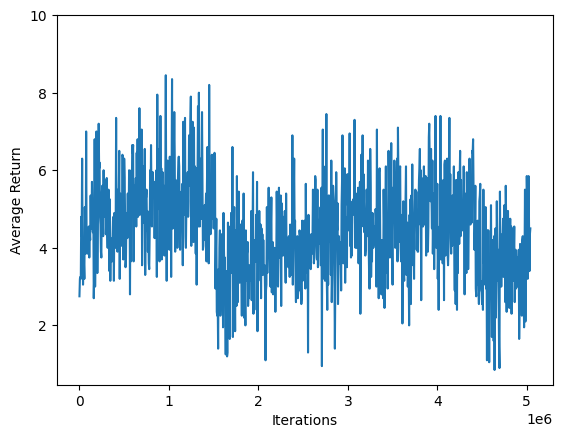

In [9]:
iterations = range(0, train_step_counter + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=10)

In [8]:
# test the agent human vs ai
def playHuman():
    policy = agent.policy
    running = True
    env = eval_env
    state = env.reset()
    pygame.init()

    while running:
        to_move = True
        env.render("human")
        mouse = pygame.mouse.get_pos()
        
        if env._envs[0].current_player == 1:
            if 75 + 100 > mouse[0] > 75 and 635 + 100 > mouse[1] > 635:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            tile = env._envs[0].tiles[env._envs[0].player_tiles[0][0]]
                            tile.rotate_tile(1)
                            env.render("human")
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        to_move = False
                        state = env.step(0)
                        env.render("human")
                        
            elif 275 + 100 > mouse[0] > 275 and 635 + 100 > mouse[1] > 635:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            tile = env._envs[0].tiles[env._envs[0].player_tiles[0][1]]
                            tile.rotate_tile(1)
                            env.render("human")
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        to_move = False
                        state = env.step(4)
                        env.render("human")
                        
            elif 475 + 100 > mouse[0] > 475 and 635 + 100 > mouse[1] > 635:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            tile = env._envs[0].tiles[env._envs[0].player_tiles[0][2]]
                            tile.rotate_tile(1)
                            env.render("human")
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        to_move = False
                        state = env.step(8)
                        env.render("human")
                        
        elif env._envs[0].current_player == 2:
            time.sleep(2)
            action_step = policy.action(state)
            env.step(action_step.action)
            env.render("human")
            to_move = False

        elif env._envs[0].current_player == -1 or env._envs[0].game_is_over():
            env.render("human")
            print("Winner: Player " + str(eval_py_env.current_player))
            running = False
                    
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                pygame.quit()
                
def playRandom():
    env = eval_env
    random = random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),env.action_spec())
    policy = agent.policy
    running = True
    state = env.reset()
    pygame.init()
    
    while running:
        to_move = True
        
        if env._envs[0].current_player == 1 and not env._envs[0].game_is_over():
            action_step = random.action(state)
            state = env.step(action_step.action)
            to_move = False
            
        elif env._envs[0].current_player == 2 and not env._envs[0].game_is_over():
            action_step = policy.action(state)
            state = env.step(action_step.action)
            to_move = False

        elif env._envs[0].current_player == -1 or env._envs[0].game_is_over():
            running = False
            pygame.quit()
            return env._envs[0].remaining_players[0]
        
        #uncomment to render
        #env.render("human")
                    
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                pygame.quit()
                
    return 0
        
playHuman()

'''
randomWins = 0
agentWins = 0
for i in range(100000):
    print(i)
    temp = playRandom()
    if temp == 1:
        randomWins += 1
    elif temp == 2:
        agentWins += 1

print("Random Policy Wins: " + str(randomWins))
print("Agent Policy Wins: " + str(agentWins))
'''

'\nrandomWins = 0\nagentWins = 0\nfor i in range(100000):\n    print(i)\n    temp = playRandom()\n    if temp == 1:\n        randomWins += 1\n    elif temp == 2:\n        agentWins += 1\n\nprint("Random Policy Wins: " + str(randomWins))\nprint("Agent Policy Wins: " + str(agentWins))\n'

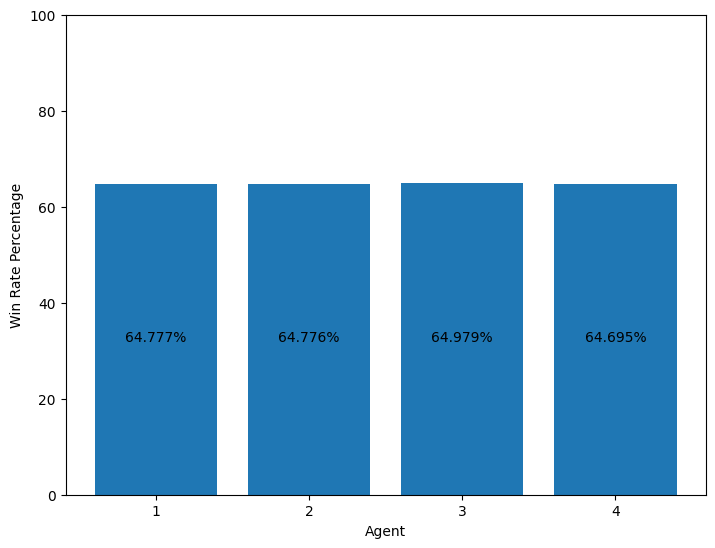

In [22]:
#plot win rate bar chart (manual entry of win %)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Win Rate Percentage')
ax.set_xlabel('Agent')
Agents = ['1', '2', '3', '4']
WinRates = [64.777, 64.776, 64.979, 64.695]
ax.bar(Agents,WinRates)
for i in range(len(Agents)):
    plt.text(i, WinRates[i]//2, str(WinRates[i])+"%", ha = 'center')
plt.ylim((0,100))
plt.show()

In [26]:
playHuman()